<a href="https://colab.research.google.com/github/trinexus2002/CD_databits/blob/main/02_Proyecto_final_Fase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://storage.googleapis.com/datasets-academy/public-img/notebooks/headers/databits-header-notebook.png" alt="Databricks Learning" style="width: 100%;">
</div>

# <center>  Proyecto Final - Fase 2  </center>

## Descripción
- En esta sección se ejecutará el preprocesamiento e ingeniería de variable en los datos de entrenamiento
- Además, se estimará por medio de la Regresión Logística la probabilidad de default en los datos de test (modelo de línea base)
  
<img alt="Caution" title="Caution" style="vertical-align: text-bottom; position: relative; height:1.3em; top:0.0em" src="https://storage.googleapis.com/datasets-academy/public-img/notebooks/icons/danger.png"/> **Disclaimer:** Este material ha sido preparado por el equipo de **handytec Academy®**. Se prohibe la publicación o reproducción de este material sin previa autorización de **handytec Academy®** - 2022 Todos los derechos reservados.

## Problema de negocio

Un problema imperante en el entorno bancario a nivel global se enfoca en el riesgo crediticio o riesgo de impago. 
  
Este aspecto hace refencia a las pérdidas que incurren los bancos dado que los prestamistas son incapaces de devolver los créditos otorgados. 

Lo cual conlleva la siguiente pregunta: **¿Cómo poder reducir el número de personas que caen en mora crediticia?** 
  
Aspecto que se aborda a continuación.

## Objetivos del proyecto

El objetivo de este proyecto es construir un modelo que los prestatarios puedan usar para ayudar a tomar las mejores decisiones financieras.

Mediante el uso de diferentes algoritmos se obtendrá la probabilidad de impago en cada individuo. El principal indicador que se va usar para ver la bonanza de los distintos modelos va a ser el AUC (Area Under the Curve) generado por las curvas ROC.

## Importar librerías y verificar versiones

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn as sk
# Librerías para visualización
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print('** Versiones Actuales | Requeridas **')
print('Python:\nVersion Actual:', sys.version, ' | Requerida >= 3.6')
print('NumPy:\nVersion Actual: {:10} | Requerida >= 1.16.2'.format(np.__version__))
print('Pandas:\nVersion Actual: {:10}| Requerida >= 1.0.1'.format(pd.__version__))
print('Scikit-learn:\nVersion Actual: {:10}| Requerida >= 0.22.1'.format(sk.__version__))
print('Matplotlib:\nVersion Actual: {:10} | Requerida >= 3.0.3'.format(matplotlib.__version__))
print('Seaborn:\nVersion Actual: {:10} |Requerida >= 0.9.0 '.format(sns.__version__))

** Versiones Actuales | Requeridas **
Python:
Version Actual: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]  | Requerida >= 3.6
NumPy:
Version Actual: 1.21.6     | Requerida >= 1.16.2
Pandas:
Version Actual: 1.3.5     | Requerida >= 1.0.1
Scikit-learn:
Version Actual: 1.0.2     | Requerida >= 0.22.1
Matplotlib:
Version Actual: 3.2.2      | Requerida >= 3.0.3
Seaborn:
Version Actual: 0.11.2     |Requerida >= 0.9.0 


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

## Descripción de las variables contenidas en el _dataset_

El _dataset_ usado proviene de la plataforma **Kaggle**, y se encuentra separado en dos partes. 

La primera parte contiene los datos que serán usados para el entrenamiento del modelo, que serán nombrados como *datos_training*. La segunda parte son los datos que se usarán para el test del modelo *datos_test*. Estas muestras contienen 150.000 y 101.503 registros, respectivamente (aunque existen algunos campos que tienen distintos valores ausentes). 

Accesso a la Competencia **Give Me Some Credit:** [Link de acceso](https://www.kaggle.com/c/GiveMeSomeCredit/overview)

Link de descarga correspondiente a cada dataset: 
* [training data](https://storage.googleapis.com/datasets-academy/Track%20Data%20Science/Proyecto%20Final/cs-training.csv)
* [test data](https://storage.googleapis.com/datasets-academy/Track%20Data%20Science/Proyecto%20Final/cs-test.csv)

* **SeriousDlqin2yrs:** Persona que tiene 90 días de morosidad vencida o peor (Si = 1 y  No = 0)
* **RevolvingUtilizationOfUnsecuredLines:** El saldo total en tarjetas de crédito y líneas de crédito personales (excepto bienes inmuebles y sin deuda a plazos) sobre la suma de los límites de crédito
* **Age:** Edad prestamista en años 
* **NumberOfTime30-59DaysPastDueNotWorse:** Número de veces que el prestatario ha caido en mora entre 30 y 59 días, pero no ha empeorado en los últimos 2 años 
* **DebtRatio:** Pagos mensuales de deuda sobre el ingreso bruto mensual 
* **MonthlyIncome:** Ingreso mensual 
* **NumberOfOpenCreditLinesAndLoans:** Número de préstamos abiertos (cuotas como préstamos para automóviles o hipotecas) y líneas de crédito 
* **NumberOfTimes90DaysLate:** Número de veces que el prestatario ha caido en mora entre 90 días o más 
* **NumberRealEstateLoansOrLines:** Número de préstamos hipotecarios e inmobiliarios, incluidas las líneas de crédito hipotecario 
* **NumberOfTime60-89DaysPastDueNotWorse:** Número de veces que el prestatario ha caido en mora entre 60 y 89 días, pero no ha empeorado en los últimos 2 años 
* **NumberOfDependents:** Número de dependientes en la familia excluyendose a si mismos (ej: cónyuge, hijos, etc.)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de los datos

### **Importante**

Recordar descargar los archivos localmente y subirlos al sistema de archivos de Google Colab

In [5]:
# Colocar la ruta del directorio correspondiente a cada dataset
ruta_training = "/content/drive/MyDrive/Colab Notebooks/Datasets/cs-training.csv"
ruta_test     = "/content/drive/MyDrive/Colab Notebooks/Datasets/cs-test.csv"

In [6]:
# Lectura de los datos usando pandas (creación de DataFrames)
datos_training = pd.read_csv(ruta_training, sep = ',', decimal = '.', index_col = 0)
datos_test     = pd.read_csv(ruta_test,     sep = ',', decimal = '.', index_col = 0)

In [7]:
# Imprimir el número de filas y columnas de ambos datasets
print('Filas y columnas - datos de entrenamiento', datos_training.shape)
print('Filas y columnas - datos de test', datos_test.shape)

Filas y columnas - datos de entrenamiento (150000, 11)
Filas y columnas - datos de test (101503, 11)


In [8]:
# Imprimir los tipos de datos de cada columna en el dataset de entrenamiento
print(datos_training.dtypes)

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


## Ingeniería de variable

### Selección de variable objetivo y predictores del DataFrame `datos_training`

In [9]:
# En la variable y colocar la variable objetivo. En la variable X todos los predictores
y = datos_training.loc[:,'SeriousDlqin2yrs']
X = datos_training.loc[:, [i for i in datos_training.columns if i != 'SeriousDlqin2yrs']]

### División en datos de training y test

Para dividir la muestra de entrenamiento en dos submuestras de _training_ y _test_, se decide guardar una proporción de 80% _training_ 20% _test_. 

En los argumentos de `train_test_split` emplear el muestreo estratificado `stratify=y` y  `random_state=0`

In [10]:
# División en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [11]:
# Imprimir las filas y columnas de los datos de training y test: para los predictores y para la variables objetivo
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120000, 10) (30000, 10) (120000,) (30000,)


### Escalamiento (variables numéricas)

In [12]:
# Selección de las etiquetas de las variables numéricas
X_num = X.select_dtypes(include=np.number).columns
print(X_num)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


### Pipeline - Ingeniería de variable

In [13]:
# Creación de un Pipeline para el preprocesamiento de las variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  MinMaxScaler(feature_range=(0, 1)))])

In [14]:
# Delimitar el preprocesamiento de variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_num)])

Crear en la variable `reg_log` el algoritmo de Regresión Logística con los siguientes argumentos: `max_iter=1000, class_weight='balanced', random_state=0, n_jobs = -1`

In [18]:
# Delimitar la configuración del algoritmo de Regresión Logística
reg_log = LogisticRegression(C=1, max_iter=1000, class_weight='balanced', random_state=0, n_jobs=-1)

### Pipeline - Ingeniería de variable y Modelo de Línea Base

In [19]:
# Creción de Pipeline para preprocesamiento y ejecución del algoritmo
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', reg_log)])

clf.fit(X_train, y_train)
print('Intercepto', reg_log.intercept_)
print('Pendientes', reg_log.coef_.round(4))

Intercepto [1.11881639]
Pendientes [[-0.851  -3.33   36.6093 -1.8925 -4.5961 -0.1717 29.2056  2.1923  7.6777
   1.2573]]


Aplicar Validación Cruzada:
1. Crear el grid de valores llamado `param_grid` con el hiperparámetro: `'classifier__C': [1, 10, 100, 1000, 10000]` 
2. En la variable `grid` asignar `GridSearchCV` con los siguientes argumentos: `cv = 10, param_grid = param_grid, estimator = clf, scoring = 'roc_auc', n_jobs = -1`
3. Realizar el ajuste con respecto a los datos de entrenamiento
4. Imprimir el hiperparámetro óptimo y el mejor score

In [29]:
# Validación Cruzada 
param_grid = [{'classifier__C': [1, 10, 100, 1000, 10000]}]
grid = GridSearchCV(cv = 10, param_grid = param_grid, estimator = clf, scoring = 'roc_auc', n_jobs = -1)
grid.fit(X_train, y_train)

# Imprimir el hiperparámetro óptimo y el mejor score

print("Mejor score = ", grid.best_score_)
print("Hiperparametro optimo = ", grid.best_params_)
print("Mejor index= ", grid.best_index_)

Mejor score =  0.7898113531356262
Hiperparametro optimo =  {'classifier__C': 10000}
Mejor index=  4


In [55]:
# Algoritmo optimizado
log_opt = LogisticRegression(multi_class = 'ovr', 
                             solver = 'lbfgs',
                             C = grid.best_params_['classifier__C'],
                             max_iter = 1000,
                             class_weight = 'balanced', 
                             random_state = 0,
                             n_jobs = -1)
log_opt2 = LogisticRegression(multi_class = 'ovr', 
                             solver = 'lbfgs',
                             C = 100000,
                             max_iter = 1000,
                             class_weight = 'balanced', 
                             random_state = 0,
                             n_jobs = -1)

In [56]:
# Creación del Pipeline para el preprocesamiento de los datos y ejecución del algoritmo optimizado
clf_opt = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', log_opt)])
clf_opt2 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', log_opt2)])
clf_opt.fit(X_train, y_train)
clf_opt2.fit(X_train, y_train)
# Clasificación de clientes (cut-off 0.5)
yHat_test2 = clf_opt2.predict(X_test)
yHat_test = clf_opt.predict(X_test)

Imprimir la matriz de confusión en forma de visualización evaluando los datos de test: `y_test` y `yHat_test`. Adicionalmente, interpretar los resultados a partir de la matriz de confusión.

Exactitud:  0.7727333333333334 0.7729
Precision:  0.17658916812256417 0.17670790747713824
Sensitividad (Recall): 0.655361596009975 0.655361596009975


Text(0.5, 24.0, 'yHat')

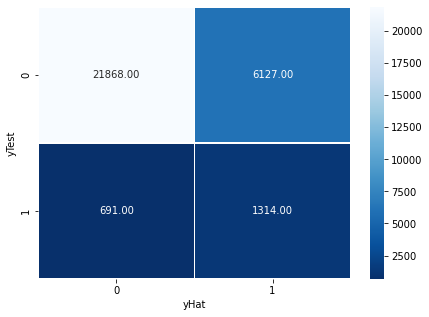

In [57]:
# Matriz de confusión
print('Exactitud: ', metrics.accuracy_score(y_test, yHat_test),metrics.accuracy_score(y_test, yHat_test2))
print('Precision: ', metrics.precision_score(y_test, yHat_test),metrics.precision_score(y_test, yHat_test2))
print('Sensitividad (Recall):', metrics.recall_score(y_test, yHat_test),metrics.recall_score(y_test, yHat_test2))
matriz_confusion = metrics.confusion_matrix(y_test, yHat_test)
matriz_confusion2 = metrics.confusion_matrix(y_test, yHat_test2)
# Graficar la matriz de Confusion
plt.figure(figsize=(7,5))
plot_matriz = sns.heatmap(matriz_confusion, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat')

Text(0.5, 24.0, 'yHat2')

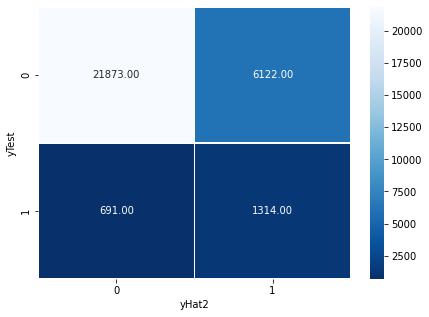

In [58]:
plt.figure(figsize=(7,5))
plot_matriz = sns.heatmap(matriz_confusion2, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat2')

Se puede apreciar en la matriz de confusion que hay una alta cantidad de falsos positivos 6127, es decir tiene una baja precision.
A pesar de que su exactitud es del 77.3%, su probabilidad de atinar correctamente a los positivos es de solo 17.7%, y solo toma el 65.5% de los verdaderos positivos.  Se podria mejorar si se tomase un C mayor de 100000, pero solo mejora los verdaderos negativos.

Imprimir la métrica del AUC para analizar el desempeño del algoritmo en los datos de test

Text(0.5, 1.0, 'Curva ROC')

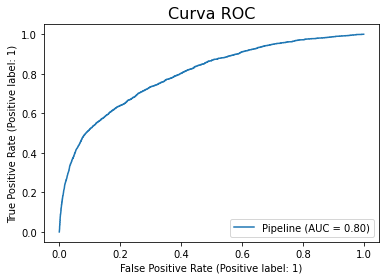

In [41]:
# Métricas de evaluación para analizar el desempeño del algoritmo (AUC)
scores = clf_opt.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, scores)
aucROC = metrics.auc(fpr, tpr)

# Calculo métrica ROC-AUC
curva_roc = metrics.RocCurveDisplay.from_estimator(clf_opt, X_test, y_test)
plt.title('Curva ROC', fontsize=16)

0.7844492002713345
0.7972331004957689
0.7986899691296852
0.7987280592945213
0.7987223938724363
0.7988278989969264


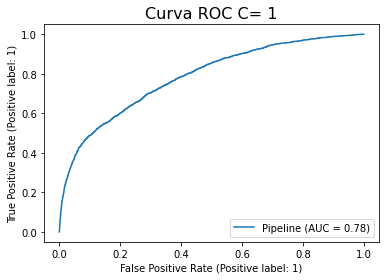

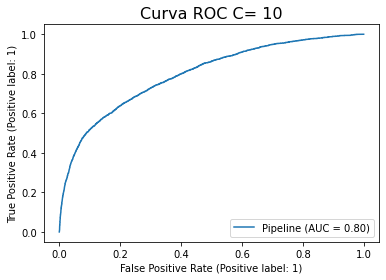

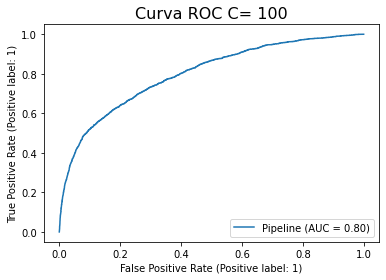

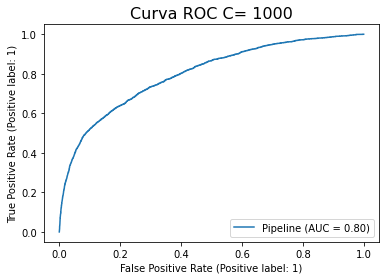

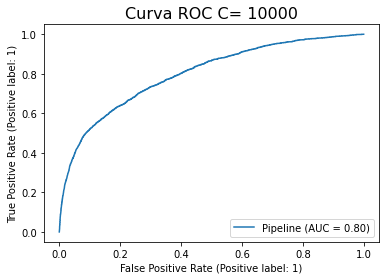

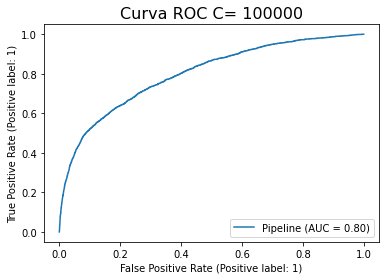

In [54]:
# Su código aquí
for i in [1, 10, 100, 1000, 10000, 100000]:
  C = i
  log_opt = LogisticRegression(multi_class = 'ovr', 
                             solver = 'lbfgs',
                             C = C,
                             max_iter = 1000,
                             class_weight = 'balanced', 
                             random_state = 0,
                             n_jobs = -1)

  clf_opt = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', log_opt)])
  clf_opt.fit(X_train, y_train)
  # Predecir con training para analizar overfitting
  yHat_train = clf_opt.predict(X_train)
  # Evaluar desempeño algortimo al prededir con test
  yHat_test = clf_opt.predict(X_test)
  # Cálculo de FPR, Recall(TPR) y puntos de corte:
  scores = clf_opt.predict_proba(X_test)[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, scores)
  # Calculo métrica ROC-AUC
  aucROC = metrics.auc(fpr, tpr)
  print(aucROC)
  # Graficar la curva ROC
  curva_roc = metrics.RocCurveDisplay.from_estimator(clf_opt, X_test, y_test)
  plt.title('Curva ROC C= ' + str(C), fontsize=16)

### Envío probabilidades de default (datos_test) - Kaggle Submission

In [42]:
X_datos_test = datos_test.loc[:, [i for i in datos_test.columns if i != 'SeriousDlqin2yrs']]
X_datos_test.shape

(101503, 10)

In [43]:
prob_default = clf_opt.predict_proba(X_datos_test)[:,1]
prob_default

array([0.40885209, 0.39326793, 0.34888299, ..., 0.23219201, 0.3788116 ,
       0.51234308])

In [44]:
df_entrega = pd.DataFrame(data=prob_default, 
                          columns = ["Probability"])

df_entrega['Id'] = range(1, prob_default.shape[0]+1)
df_entrega = df_entrega[["Id", "Probability"]] 

In [45]:
df_entrega.to_csv('./entrega_kaggle_rl.csv', index=False, sep = ',', decimal='.', encoding='utf-8')


<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://storage.googleapis.com/datasets-academy/public-img/notebooks/headers/databits-footer-notebook.png" alt="Databricks Learning" style="width: 100%;">
</div>